# Сравнение рекуррентных нейронных сетей

## Подключение библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, Input
from helpful_functions import train_val_test_split, \
                              create_one_step_sequences, create_multi_step_sequences, \
                              denormalize_one_step, denormalize_multi_step


## 1. Загрузка данных


In [2]:
file_path = './dataset/preprocessed_data.csv'
df = pd.read_csv(file_path)

df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)

target_feature = 'Global_active_power'
window_size = 60
n_steps_ahead = 10
test_ratio = 0.10
val_ratio = 0.10

train_data, val_data, test_data = train_val_test_split(df, val_ratio, test_ratio)

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)
test_scaled = scaler.transform(test_data)

target_idx = df.columns.get_loc(target_feature)

X_train, y_train = create_one_step_sequences(train_scaled, target_idx, window_size)
X_val, y_val = create_one_step_sequences(val_scaled, target_idx, window_size)
X_test, y_test = create_one_step_sequences(test_scaled, target_idx, window_size)

features_count = train_data.shape[1]

## 2. Сравнение моделей

### 2.1. Инициализация моделей

In [ ]:
model_rnn = Sequential([
    Input(shape=(window_size, features_count)),
    SimpleRNN(50, activation='tanh'),
    Dense(1)
])
model_rnn.compile(optimizer='adam', loss='mse')

model_lstm = Sequential([
    Input(shape=(window_size, features_count)),
    LSTM(50, activation='tanh'),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')

### 2.2. Обучение

#### RNN

In [5]:
history_rnn = model_rnn.fit(
    X_train, y_train,
    epochs=5,
    batch_size=256,
    validation_data=(X_val, y_val)
)

Epoch 1/5
6485/6485 ━━━━━━━━━━━━━━━━━━━━ 57s 9ms/step - loss: 0.0026 - val_loss: 3.9761e-04
Epoch 2/5
6485/6485 ━━━━━━━━━━━━━━━━━━━━ 81s 12ms/step - loss: 5.7799e-04 - val_loss: 3.9559e-04
Epoch 3/5
6485/6485 ━━━━━━━━━━━━━━━━━━━━ 87s 13ms/step - loss: 5.5651e-04 - val_loss: 4.2267e-04
Epoch 4/5
6485/6485 ━━━━━━━━━━━━━━━━━━━━ 87s 13ms/step - loss: 5.4145e-04 - val_loss: 3.7894e-04
Epoch 5/5
6485/6485 ━━━━━━━━━━━━━━━━━━━━ 106s 16ms/step - loss: 5.3326e-04 - val_loss: 3.8716e-04


#### LSTM

In [6]:
history_lstm = model_lstm.fit(
    X_train, y_train,
    epochs=5,
    batch_size=256,
    validation_data=(X_val, y_val)
)

Epoch 1/5
6485/6485 ━━━━━━━━━━━━━━━━━━━━ 369s 57ms/step - loss: 7.6210e-04 - val_loss: 3.7903e-04
Epoch 2/5
6485/6485 ━━━━━━━━━━━━━━━━━━━━ 388s 60ms/step - loss: 5.2851e-04 - val_loss: 3.6807e-04
Epoch 3/5
6485/6485 ━━━━━━━━━━━━━━━━━━━━ 401s 62ms/step - loss: 5.1094e-04 - val_loss: 3.7110e-04
Epoch 4/5
6485/6485 ━━━━━━━━━━━━━━━━━━━━ 307s 47ms/step - loss: 4.9927e-04 - val_loss: 3.5695e-04
Epoch 5/5
6485/6485 ━━━━━━━━━━━━━━━━━━━━ 297s 46ms/step - loss: 4.8427e-04 - val_loss: 3.5741e-04


### Сохранение моделей

In [7]:
from tensorflow.keras.models import load_model

model_rnn.save('./models/my_rnn_model.keras')
model_lstm.save('./models/my_lstm_model.keras')

# Чтобы подключить заново
# loaded_model_rnn = load_model('models/my_rnn_model.keras')
# loaded_model_lstm = load_model('models/my_lstm_model.keras')

### 2.3 Предсказания

In [8]:
y_pred_rnn_scaled = model_rnn.predict(X_test)
y_pred_lstm_scaled = model_lstm.predict(X_test)

6484/6484 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
6484/6484 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step


### 2.4. Денормализация

In [9]:
y_pred_rnn_unscaled = denormalize_one_step(scaler, y_pred_rnn_scaled, target_feature, df.columns)
y_pred_lstm_unscaled = denormalize_one_step(scaler, y_pred_lstm_scaled, target_feature, df.columns)

### 2.5. Оценка точности

In [20]:
y_test_real_unscaled = denormalize_one_step(scaler, y_test, target_feature, df.columns)

mse_rnn = mean_squared_error(y_test_real_unscaled, y_pred_rnn_unscaled)
mse_lstm = mean_squared_error(y_test_real_unscaled, y_pred_lstm_unscaled)

print('MSE:')
print(f'RNN {mse_rnn:.6f}')
print(f'LSTM {mse_lstm:.6f}')

MSE:
RNN 0.040975
LSTM 0.037051


### 2.6. Визуализация предсказанных и реальных значений

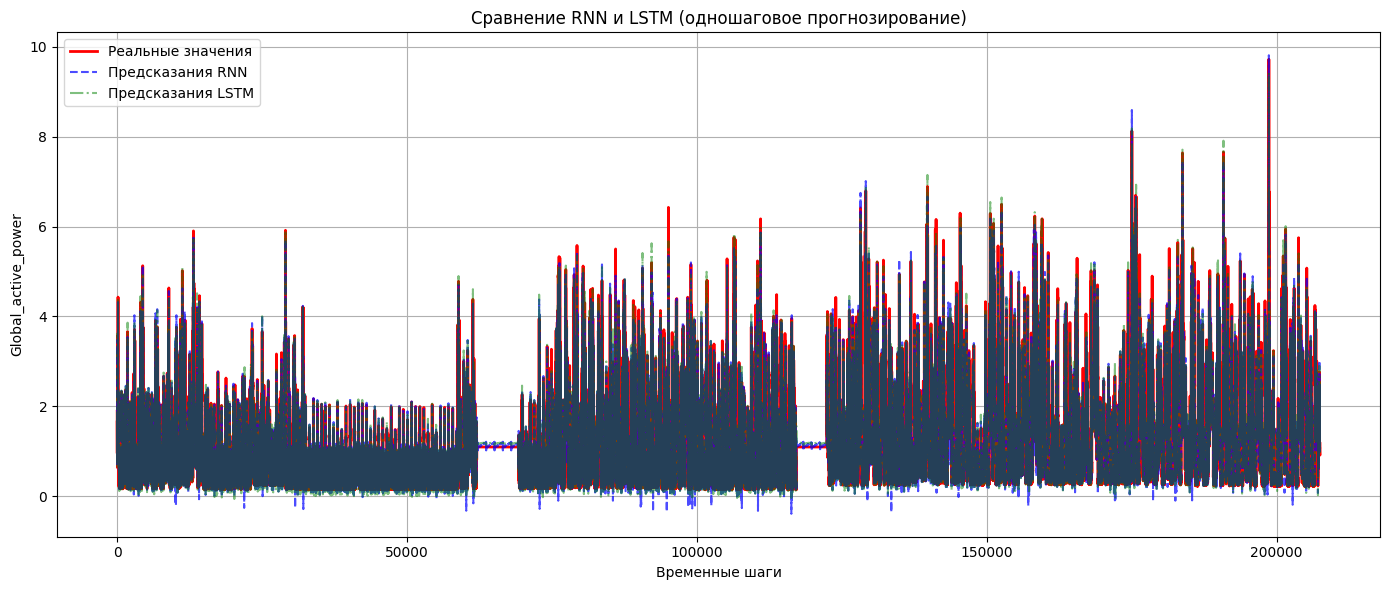

In [22]:
plt.figure(figsize=(14, 6))
plt.plot(y_test_real_unscaled, label='Реальные значения', color='red', linewidth=2, alpha=1)
plt.plot(y_pred_rnn_unscaled, label='Предсказания RNN', color='blue', linestyle='--', alpha=0.7)
plt.plot(y_pred_lstm_unscaled, label='Предсказания LSTM', color='green', linestyle='-.', alpha=0.5)
plt.title('Сравнение RNN и LSTM (одношаговое прогнозирование)')
plt.xlabel('Временные шаги')
plt.ylabel('Global_active_power')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()